# Personal Information
Name: **Diana Nigmatullina**

StudentID: **15552225**

Email: [**diana.nigmatullina@student.uva.nl**](diana.nigmatullina@student.uva.nl)

Submitted on: **23.03.2025**

GitHub link: [GitHub repository](https://github.com/admirallllllll/Master-Thesis.git)


# Data Context

This dataset consists of limit order book (LOB) data for the DOGE/USDT trading pair on the Binance exchange. The data captures market activity at a high frequency, including bid (buy) and ask (sell) orders, along with their respective prices and quantities.
Market makers use limit order books to place and adjust orders dynamically, aiming to provide liquidity and earn profits from the bid-ask spread. This dataset is crucial for analyzing market microstructure, understanding liquidity dynamics, and training Reinforcement Learning (RL) algorithms for optimal market-making strategies.
Each file represents one day of trading data, recorded at nanosecond precision, making it suitable for high-frequency trading (HFT) analysis.


EDA is less critical in RL compared to traditional ML since RL agents learn by interacting with the environment rather than relying on static datasets. Unlike supervised learning, RL does not require extensive feature engineering, and its data distribution constantly evolves as the agent explores.
However, EDA is still useful for understanding the environment (state variables, market structure), detecting anomalies (unusual spreads, liquidity drops), ensuring meaningful RL features (order flow imbalance, bid-ask spread).

# Data Description

### **Data Structure Description**

The dataset consists of 29 separate CSV files, each representing one full day of trading data for the DOGE/USDT pair on the Binance exchange. This data captures high-frequency snapshots of the limit order book (LOB), allowing detailed observation of market microstructure over nearly a month.

#### **File Structure**
- 1 file = 1 day of LOB data
- 29 files = 29 trading days in total
- Each file contains thousands of rows, depending on the activity level of that day

#### **Order Book Depth**
- Each snapshot records the top 25 levels of the order book:
  - **`asks[i].price` and `asks[i].amount`**: Sell-side price and volume at level *i* (where *i* ranges from 0 to 24)
  - **`bids[i].price` and `bids[i].amount`**: Buy-side price and volume at level *i*

#### **Time Columns**
- `timestamp`: Captures the server-side timestamp of the order book snapshot in nanoseconds
- `local_timestamp`: Captures the client-side or local system timestamp, also in nanoseconds
- Both timestamps are converted to readable datetime format during preprocessing

#### **Other Metadata Columns**
- `exchange`: The source of data (always "binance")
- `symbol`: The trading pair (always "DOGEUSDT")

In [139]:
# Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Data Loading

Since the whole data from 29 files contains 1.5gb of information, the good idea will be to use only the top 5 ask and bid levels instead of all 25 in order to reduce the file size in memory. It’s common in financial research to focus on the top 5 levels because: they represent most of the liquidity and trading activity, they're faster to process and reduce memory usage significantly, they're enough for modeling market dynamics, especially for RL agents.

In [ ]:
data_dir = "/Users/diananigmatullina/Downloads/data_thesis"  
all_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".csv.gz")])

df_list = []

for file in all_files:
    df_tmp = pd.read_csv(file)

    # Keep only top 5 levels
    keep_cols = ['timestamp', 'local_timestamp', 'exchange', 'symbol']
    for i in range(5):
        keep_cols += [f'asks[{i}].price', f'asks[{i}].amount', f'bids[{i}].price', f'bids[{i}].amount']
    
    df_tmp = df_tmp[keep_cols]
    df_list.append(df_tmp)

df = pd.concat(df_list, ignore_index=True)

In [218]:
df.head()

,timestamp,local_timestamp,exchange,symbol,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,...,bids[2].price,bids[2].amount,asks[3].price,asks[3].amount,bids[3].price,bids[3].amount,asks[4].price,asks[4].amount,bids[4].price,bids[4].amount
0,1735689601703988,1735689601703988,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,27345,...,0.31598,3817,0.31604,24147,0.31597,9272,0.31605,31106,0.31596,7766
1,1735689601974000,1735689601975707,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,30507,...,0.31598,3817,0.31604,21846,0.31597,9272,0.31605,31106,0.31596,7766
2,1735689602074000,1735689602075995,binance,DOGEUSDT,0.31601,126244,0.316,87917,0.31602,30507,...,0.31598,3817,0.31604,21846,0.31597,9272,0.31605,33406,0.31596,7766
3,1735689602274000,1735689602275736,binance,DOGEUSDT,0.31601,115444,0.316,87917,0.31602,32089,...,0.31598,3817,0.31604,21846,0.31597,9272,0.31605,33406,0.31596,7766
4,1735689602374000,1735689602375702,binance,DOGEUSDT,0.31601,115444,0.316,87917,0.31602,32880,...,0.31598,3817,0.31604,29757,0.31597,9272,0.31605,33406,0.31596,7766


### Analysis 1: 


In [168]:
# Timestamp Conversion
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ns")
df["local_timestamp"] = pd.to_datetime(df["local_timestamp"], unit="ns")

In [ ]:
# Basic Info  
print(df.info())

In [174]:
# Adding Features
df["spread"] = df["asks[0].price"] - df["bids[0].price"]
df["total_ask_volume"] = sum(df[f"asks[{i}].amount"] for i in range(5))
df["total_bid_volume"] = sum(df[f"bids[{i}].amount"] for i in range(5))

#### `spread`
- The bid-ask spread, a direct indicator of market liquidity and transaction cost.
- Narrow spreads mean tighter markets and lower risk for market makers. It can also reflect market stability or volatility.
- The agent can use spread size to decide how aggressively to quote or when to stay out of the market.

---

#### `volume`
- The depth of the order book** on the ask and bid sides respectively, across the top 5 levels.
- These volumes indicate available liquidity and market imbalance.
- Market makers need this to evaluate supply/demand pressure. For example:
  - If bid volume ≫ ask volume → potential buying pressure
  - If ask volume ≫ bid volume → potential selling pressure

### Analysis 2: 

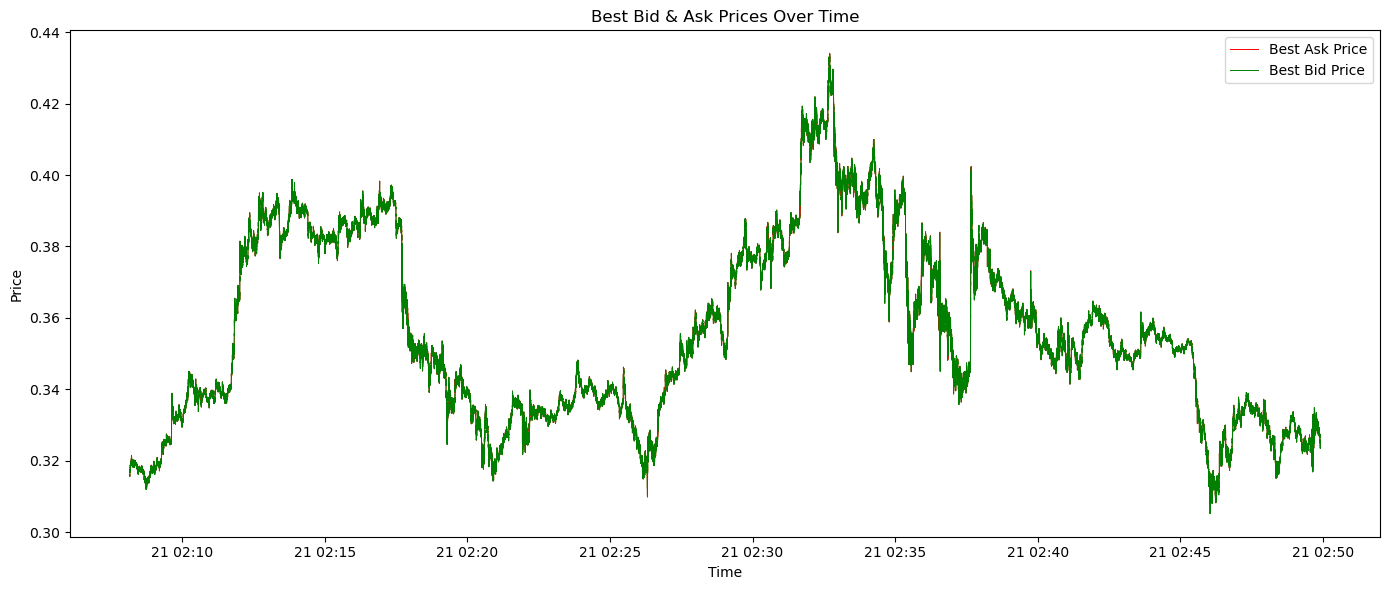

In [178]:
# Plot Bid & Ask Prices
plt.figure(figsize=(14, 6))
plt.plot(df["timestamp"], df["asks[0].price"], label="Best Ask Price", color='red', linewidth=0.7)
plt.plot(df["timestamp"], df["bids[0].price"], label="Best Bid Price", color='green', linewidth=0.7)
plt.title("Best Bid & Ask Prices Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig("top5_bid_ask_prices.png")
plt.show()

This plot shows best bid (green) and ask (red) prices for DOGE/USDT over the trading session.

#### Key Insights:

- Price quickly rises from 0.32 to over 0.42, likely due to strong buying interest or market news.

- The market shows rapid price changes, suggesting unstable order flow or low liquidity.

- The price drops back toward 0.33, indicating mean reversion or profit-taking behavior.

- Bid and ask prices are nearly overlapping, confirming high liquidity and efficient pricing.

#### Relevance to RL Market Making:
These conditions demonstrate the need for RL agents to adapt to price rises, volatility, and changing liquidity, making this a valuable segment for training or evaluation.

### Analysis 3:

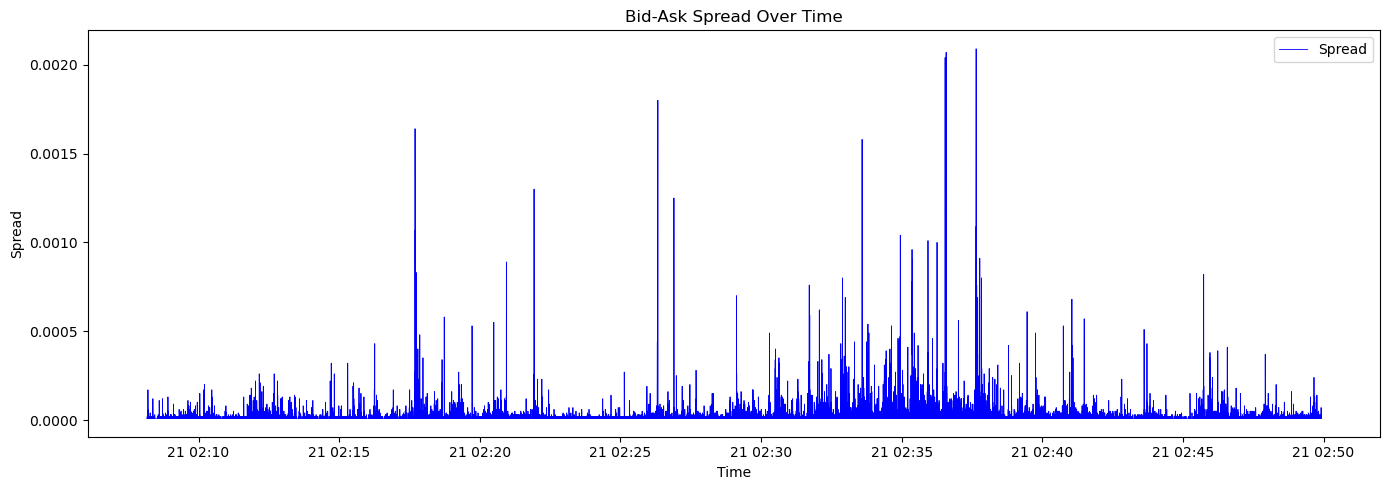

In [31]:
# Plot Spread over time
plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["spread"], color='blue', label="Spread", linewidth=0.6)
plt.title("Bid-Ask Spread Over Time")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.tight_layout()
plt.savefig("top5_spread_over_time.png")
plt.show()

This plot shows how the bid-ask spread evolves over time for DOGE/USDT.

#### Key Insights:

**Mostly Tight Spread**:  
   - For the majority of the time window, the spread remains very small, indicating a highly liquid and efficient market.

**Frequent Spikes in Spread**:  
   - Noticeable sharp spikes occur throughout the plot, especially around 02:20 to 02:40.
   - These may correspond to sudden drops in liquidity or larger market orders.

**Volatile Spread Phase**:  
   - The middle portion of the plot shows increased and sustained spread volatility, suggesting instability or increased uncertainty in the market during that window.

#### Relevance for RL Market Making:
- Spread size is critical for deciding where to place quotes.
- An RL agent can avoid quoting during high-spread periods.
- Identifying and reacting to these spikes is key to minimizing losses.

### Analysis 4:

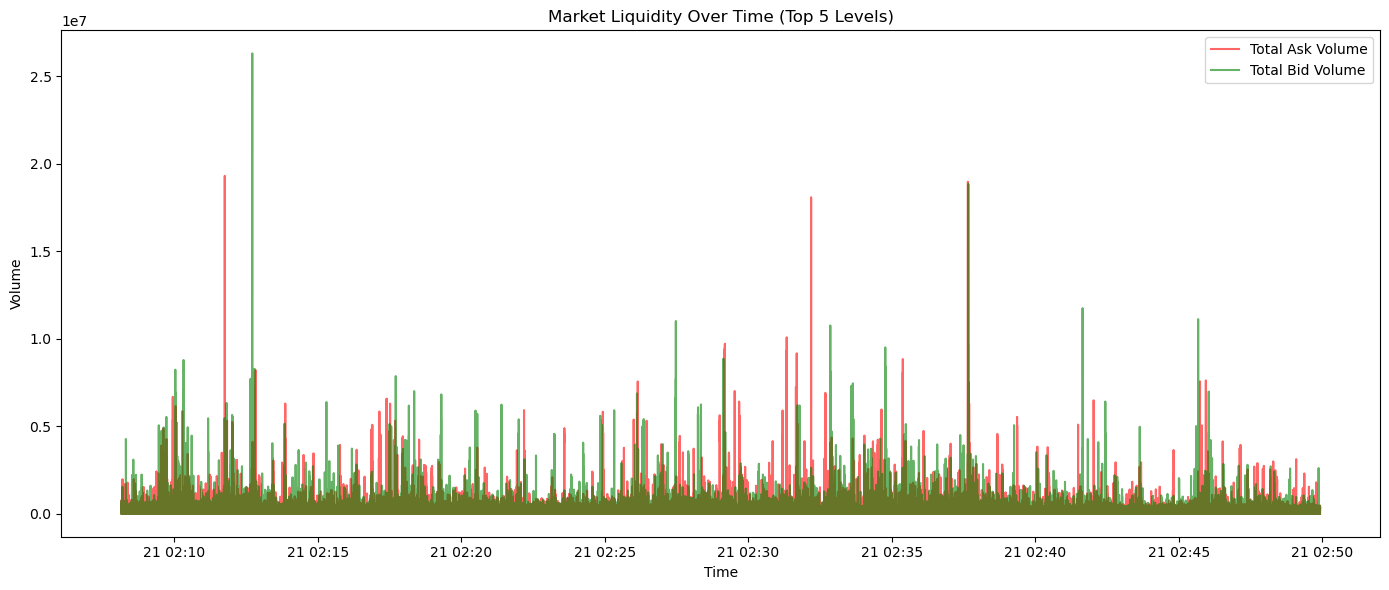

In [38]:
# Plot Market liquidity
plt.figure(figsize=(14, 6))
plt.plot(df["timestamp"], df["total_ask_volume"], label="Total Ask Volume", color='red', alpha=0.6)
plt.plot(df["timestamp"], df["total_bid_volume"], label="Total Bid Volume", color='green', alpha=0.6)
plt.title("Market Liquidity Over Time (Top 5 Levels)")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()
plt.savefig("top5_market_liquidity.png")
plt.show()

This plot shows the total bid (green) and ask (red) volumes over time, aggregated from the top 5 levels of the order book.

#### Key Insights:

**High Liquidity with Occasional Spikes**  
   - Most of the time, liquidity remains in a moderate and balanced range.
   - Several sharp volume spikes are observed on both sides, possibly reflecting large incoming orders, liquidity injections, or market reactions to volatility.

**Bid/Ask Imbalance Moments**  
   - In some intervals, bid volume exceeds ask volume, and vice versa.
   - These imbalances may indicate buy/sell pressure.

**Liquidity is Dynamic**  
   - Volumes fluctuate continuously.
   - These fluctuations are crucial for an RL agent to decide when to quote tighter or widen spreads to avoid risk.

#### Relevance for RL Market Making:
Market liquidity affects execution risk and spread profitability. An RL agent that observes liquidity changes can:
- Avoid quoting during liquidity droughts or spikes,
- Adjust aggressiveness based on depth,
- Use bid/ask imbalance to anticipate price moves.

### Analysis 5:

In [ ]:
# Outlier detection
df["spread_zscore"] = (df["spread"] - df["spread"].mean()) / df["spread"].std()
outliers = df[df["spread_zscore"].abs() > 3]
outliers.to_csv("top5_spread_outliers.csv", index=False)
outliers.head()

In [56]:
# Calculate spread range stats
min_spread = outliers["spread"].min()
max_spread = outliers["spread"].max()
mean_spread = outliers["spread"].mean()

# Calculate spread_zscore range stats
min_zscore = outliers["spread_zscore"].min()
max_zscore = outliers["spread_zscore"].max()
mean_zscore = outliers["spread_zscore"].mean()

{
    "Min Spread (USDT)": min_spread,
    "Max Spread (USDT)": max_spread,
    "Mean Spread (USDT)": mean_spread,
    "Min Z-score": min_zscore,
    "Max Z-score": max_zscore,
    "Mean Z-score": mean_zscore
}

{'Min Spread (USDT)': 2.999999999997449e-05,
 'Max Spread (USDT)': 0.0020899999999999808,
 'Mean Spread (USDT)': 8.161269941557396e-05,
 'Min Z-score': 4.280848420491329,
 'Max Z-score': 448.07750929193895,
 'Mean Z-score': 15.400044371561572}

These statistics describe the behavior of extreme bid-ask spread events (spread Z-score > 3), revealing important market dynamics.


#### Spread Range
- **Min Spread**: `0.00003 USDT`  
- **Max Spread**: `0.00209 USDT`  
- **Mean Spread**: `0.000082 USDT`

The maximum spread is about 70x the minimum and ~25x higher than the mean, which clearly highlights rare but impactful liquidity shocks.
Such events may lead to wider execution costs and are risky periods for market-making.


#### Z-Score Range
- **Min Z-score**: `4.28`
- **Max Z-score**: `448.08`
- **Mean Z-score**: `15.40`

The extreme maximum Z-score (> 448) indicates the presence of rare, highly unusual spread spikes.  
Even the average Z-score (15.4) is significantly above the outlier threshold (3).


#### Relevance for RL Market Making
An RL agent trained with this awareness can:
- Avoid quoting during such periods
- Widen its spread
- Use spread Z-score as a feature for safer, more adaptive behavior

### Analysis 6:

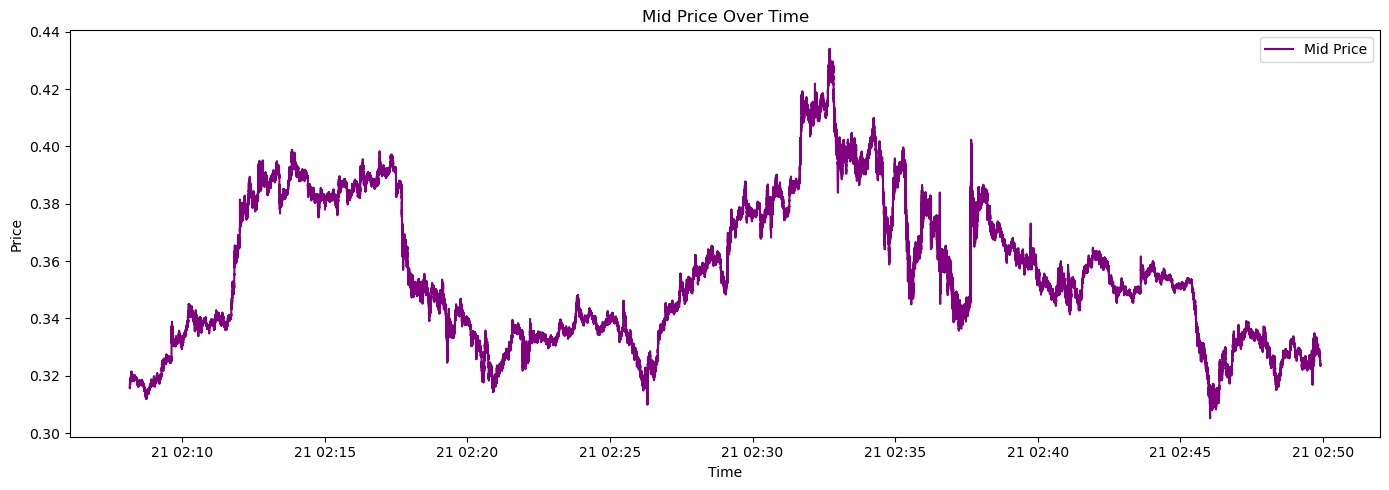

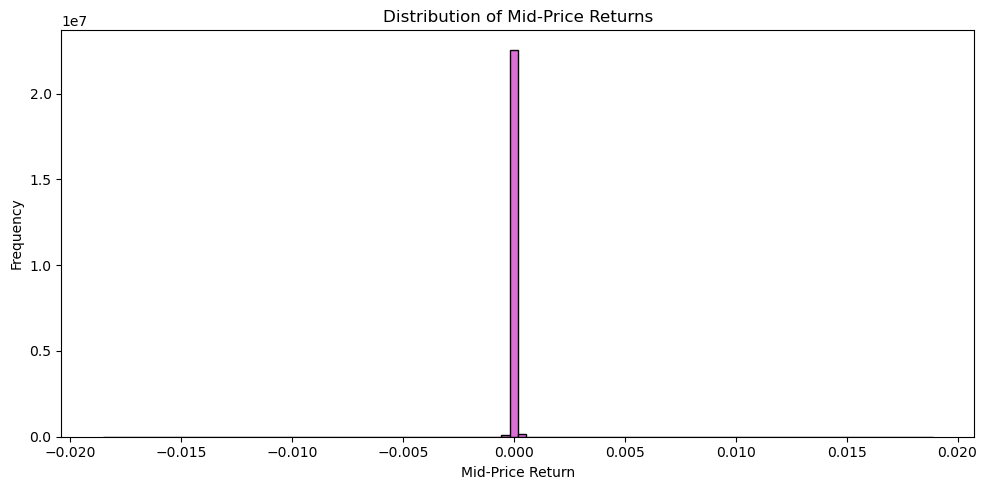

In [64]:
# Mid-Price and Mid-Price Return
df["mid_price"] = (df["asks[0].price"] + df["bids[0].price"]) / 2
df["mid_price_return"] = df["mid_price"].pct_change()

# Plot Mid-Price over Time
plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["mid_price"], color='purple', label='Mid Price')
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Mid Price Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Distribution of Mid-Price Returns
plt.figure(figsize=(10, 5))
plt.hist(df["mid_price_return"].dropna(), bins=100, color="orchid", edgecolor='black')
plt.xlabel("Mid-Price Return")
plt.ylabel("Frequency")
plt.title("Distribution of Mid-Price Returns")
plt.tight_layout()
plt.show()

The mid-price is the average of the best bid and best ask prices at any given moment:
$$
\text{mid\_price} = \frac{\text{best\_bid} + \text{best\_ask}}{2}
$$
It reflects the fair value of the asset based on current market supply and demand. 

The first plot shows how the mid-price evolves throughout the selected trading window.

#### Key Insights:
- The mid-price demonstrates clear trending.
- Sharp upward and downward moves suggest price momentum and volatility spikes, which are critical signals for a reinforcement learning (RL) agent.
- The curve is smoother than raw bid/ask lines, making it an ideal target for predicting market direction.

The histogram (second plot) shows the distribution of mid-price returns, which are calculated as:
$$
\text{return}_t = \frac{\text{mid\_price}_t - \text{mid\_price}_{t-1}}{\text{mid\_price}_{t-1}}
$$

#### Key Insights:
- Most returns are centered very close to zero, indicating that small fluctuations dominate.
- The return distribution is highly peaked.


#### Relevance to RL Market Making:
- Mid-price is an important component of an RL agent, helping it decide where to quote.
- Mid-price returns can serve as labels for predicting direction or volatility, or as part of a reward function.
- Understanding return distribution helps model risk.

### Analysis 7:

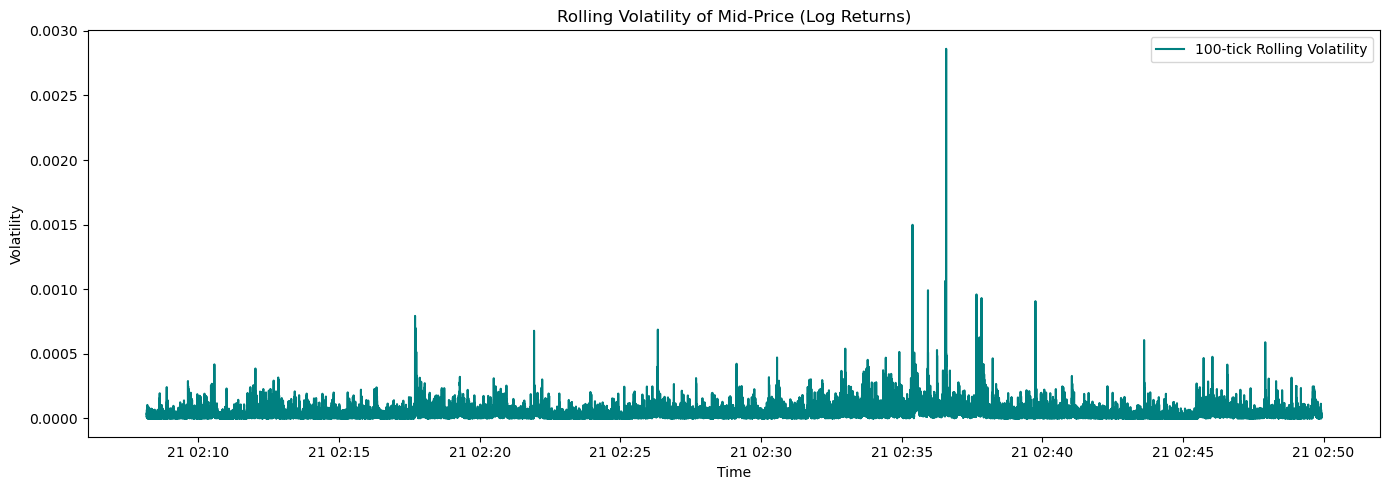

In [84]:
# Compute log returns
df["log_return"] = np.log(df["mid_price"] / df["mid_price"].shift(1))

# Rolling volatility 
rolling_window = 100
df["rolling_volatility"] = df["log_return"].rolling(window=rolling_window).std()

# Plot Rolling Volatility
plt.figure(figsize=(14, 5))
plt.plot(df["timestamp"], df["rolling_volatility"], label=f"{rolling_window}-tick Rolling Volatility", color='teal')
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Rolling Volatility of Mid-Price (Log Returns)")
plt.legend()
plt.tight_layout()
plt.show()

This plot displays the rolling volatility of log returns derived from the mid-price over time, using a 100-tick window.

- Volatility measures how much a price fluctuates over time (a key indicator of market risk).
- Rolling volatility calculates the standard deviation of log returns within a moving time window (here, 100 snapshots).

$$
\text{Volatility}_t = \text{std}(\log(\frac{p_t}{p_{t-1}})) \text{ over previous N ticks}
$$
- This helps detect short-term risk changes.

#### Key Insights:

- For most of the period, volatility remains low and stable.
- However, there are sharp volatility spikes, especially around 02:35, which can reflect:
  - Sudden order book changes
  - Large trades
  - Temporary liquidity drops
- These spikes indicate risky moments when market makers may want to widen spreads or pause quoting.

#### Relevance for RL Market Making:

- Rolling volatility is an important feature for RL agents to:
  - Adjust quoting strategy dynamically
  - Reduce risk during unstable periods

### Analysis 8 - Baseline Model:

In [155]:
df["mid_price"] = (df["asks[0].price"] + df["bids[0].price"]) / 2

def fixed_spread(mid_price, spread=0.0005):
    bid = mid_price - spread / 2
    ask = mid_price + spread / 2
    return bid, ask

# Initialize state
cash = 0.0
inventory = 0
spread = 0.0005  
inventory_list = []
pnl_list = []
mid_prices = df["mid_price"].values
timestamps = df["timestamp"].values


# Run simulation
for t in range(1, len(df)):
    mid = mid_prices[t]
    bid, ask = fixed_spread_strategy(mid, spread)

    bid = df["bids[0].price"].iloc[t] + 0.00001
    ask = df["asks[0].price"].iloc[t] - 0.00001

    if market_best_ask <= bid:
        inventory += 1
        cash -= bid
    
    if market_best_bid >= ask:
        inventory -= 1
        cash += ask

    max_inventory = 100

    if inventory < max_inventory and market_best_ask <= bid:
        inventory += 1
        cash -= bid
    
    if inventory > -max_inventory and market_best_bid >= ask:
        inventory -= 1
        cash += ask

        
    # PnL
    market_value = inventory * mid
    pnl = cash + market_value
    pnl_list.append(pnl)
    inventory_list.append(inventory)

    if t > 3000 and (inventory != 0 or cash != 0):
        break

#### Fixed Spread 
- This is a simple, rule-based baseline where the agent continuously quotes:
  - A buy (bid) slightly below mid-price
  - A sell (ask) slightly above mid-price
- The spread between bid and ask is fixed, and the agent profits from the bid-ask spread if both sides are filled.

It doesn't care how much it holds.

In [157]:
print(f"Final PnL: {pnl_list[-1]:.4f}")
print(f"Max Inventory: {max(inventory_list)}")
print(f"Min Inventory: {min(inventory_list)}")
print(f"Average Inventory: {np.mean(inventory_list):.2f}")

Final PnL: 1.3150
Max Inventory: 2141
Min Inventory: -529
Average Inventory: 685.93


**PnL (Profit and Loss):**  
$$
\text{PnL} = \text{Cash} + (\text{Inventory} \times \text{Mid-Price})
$$ 
Measures how much profit or loss the agent has made.

**Inventory:**  
Tracks the net position held by the agent:  
$$
  \text{Inventory} = \text{Buys} - \text{Sells}
$$

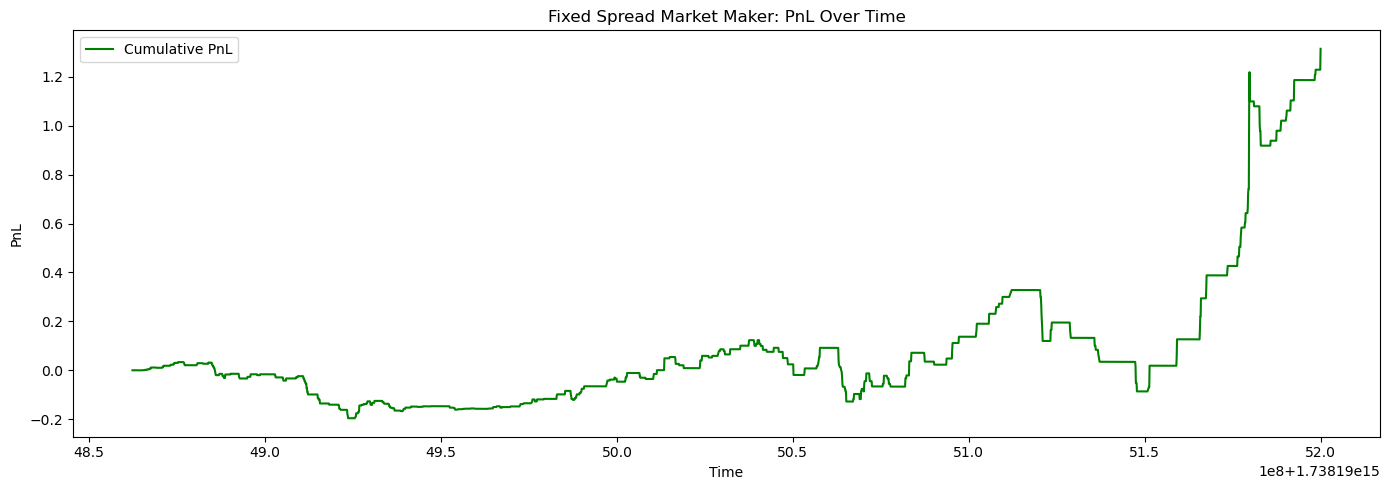

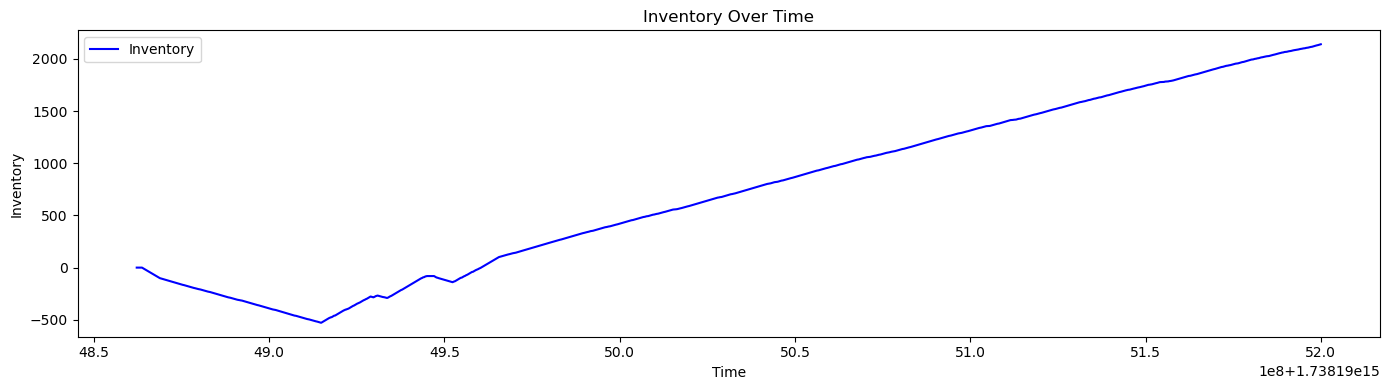

In [161]:
aligned_timestamps = timestamps[-len(pnl_list):]

# Plot PnL
plt.figure(figsize=(14, 5))
plt.plot(aligned_timestamps, pnl_list, label="Cumulative PnL", color="green")
plt.xlabel("Time")
plt.ylabel("PnL")
plt.title("Fixed Spread Market Maker: PnL Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Plot Inventory
plt.figure(figsize=(14, 4))
plt.plot(aligned_timestamps, inventory_list, label="Inventory", color="blue")
plt.xlabel("Time")
plt.ylabel("Inventory")
plt.title("Inventory Over Time")
plt.legend()
plt.tight_layout()
plt.show()


#### PnL Over Time

- PnL (Profit and Loss) represents the agent's total return.
- Initially, the PnL lies below zero, indicating some early losses.
- Over time, the strategy recovers and becomes profitable.
- The sharp rise at the end may be the result of favorable price movement while holding a long position.


#### Inventory Over Time

- Inventory tracks the number of DOGE units held by the agent.
- The plot shows a significant raise of inventory.
- The path shows that the strategy was:
  - Initially net selling,
  - Then changed into buying.
- The agent buys more often than it sells.

### Conclusion

The EDA highlighted key patterns in spread, liquidity, volatility, and price movement, highlighting both stability and occasional anomalies in the market. The fixed spread baseline model showed realistic trading behavior, small positive PnL, but suffered from large inventory drift — making it a useful, but limited benchmark for future RL agents.